In [ ]:
!wget https://www.dropbox.com/s/9019cpkapt5zm4w/Pic_OralCancer.rar?dl=0

--2023-06-24 17:24:21--  https://www.dropbox.com/s/9019cpkapt5zm4w/Pic_OralCancer.rar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9019cpkapt5zm4w/Pic_OralCancer.rar [following]
--2023-06-24 17:24:21--  https://www.dropbox.com/s/raw/9019cpkapt5zm4w/Pic_OralCancer.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc90f16f1368352f01b21ee13c54.dl.dropboxusercontent.com/cd/0/inline/B-n0DuuOAV4pUu3T2mz5Too4oSy4ZIHQB666tcnGBuyq0dXHWU43opZ6ElOzFXh2J1SSQJBEyEbLPZtGTXEMI5vLWNazX23RMyRsiPy4XfjNKBI1ysTsSPnXvP5JSoA7pL1chbX1_4ASLhyMXaWyX9Z-_rzCMxEb5h19gExCvlNpTQ/file# [following]
--2023-06-24 17:24:21--  https://uc90f16f1368352f01b21ee13c54.dl.dropboxusercontent.com/cd/0/inline/B-n0DuuOAV4pUu3T2mz5Too4oSy4ZIHQB666tcnGBuyq0dXHWU43opZ6E

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/Pic_OralCancer.rar?dl=0")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.6 MB/s eta 0:00:00
patool: Extracting /content/Pic_OralCancer.rar?dl=0 ...
patool: running /usr/bin/unrar x -- /content/Pic_OralCancer.rar?dl=0
patool:     with cwd='./Unpack_okpkw9x6'
patool: ... /content/Pic_OralCancer.rar?dl=0 extracted to `Pic_OralCancer'.


'Pic_OralCancer'

In [ ]:
# Count number of images in respective classes
#ROOT_DIR = "/content/train"
ROOT_DIR = "/content/Pic_OralCancer"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

image_count=number_of_images.items()
print(image_count)

dict_items([('non-cancer', 44), ('cancer', 87)])


In [ ]:
import os
import random
import cv2
import imgaug.augmenters as iaa

def augment_images(input_path, output_path, cancer_type):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Define augmentations
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            sometimes(iaa.Affine(rotate=(-45, 45))),
            sometimes(iaa.GaussianBlur(sigma=(0, 3.0))),
            sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
            sometimes(iaa.Multiply((0.5, 1.5), per_channel=0.5)),
            sometimes(iaa.ContrastNormalization((0.75, 1.5), per_channel=0.5)),
            sometimes(iaa.Grayscale(alpha=(0.0, 1.0))),
        ],
        random_order=True
    )

    for filename in os.listdir(input_path):
        if not filename.endswith('.png') and not filename.endswith('.jpg') and not filename.endswith('.jpeg'):
            continue

        # Load image
        image = cv2.imread(os.path.join(input_path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Augment images based on cancer type
        if cancer_type == 'cancer':
            n_augmentations = random.randint(4, 5)
        else:
            n_augmentations = random.randint(5, 8)

        images_aug = seq.augment_images([image] * n_augmentations)

        # Save augmented images to output directory
        for i in range(n_augmentations):
            output_filename = os.path.splitext(filename)[0] + f'_aug{i+1}.png'
            cv2.imwrite(os.path.join(output_path, output_filename), images_aug[i], params=[cv2.IMWRITE_PNG_COMPRESSION, 9])


In [ ]:
#Test cancer Images

input_path = '/content/Pic_OralCancer/non-cancer'
output_path = '/content/Pic_OralCancer/non-cancer'
cancer_type = 'non-cancer'

augment_images(input_path, output_path, cancer_type)

In [ ]:
#Test cancer Images
#augment_images("/content/test/cancer", "/content/test/cancer", "cancer")
input_path = '/content/Pic_OralCancer/cancer'
output_path = '/content/Pic_OralCancer/cancer'
cancer_type = 'cancer'

augment_images(input_path, output_path, cancer_type)

**Model Creation**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
# Count number of images in respective classes
ROOT_DIR = "/content/Pic_OralCancer"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

image_count=number_of_images.items()

In [ ]:
def datafolder(p,split):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./"+p+"/"+dir)
    for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)) ,
                                size =(math.floor(split*number_of_images[dir])-5),
                                replace=False ):
      O = os.path.join(ROOT_DIR,dir,img)  #path
      D = os.path.join("./"+p,dir)
      shutil.copy(O,D)
      os.remove(O)

  else :
    print(f"{p}Folder exists")

In [ ]:
datafolder("train",0.7)
datafolder("val",0.3)

trainFolder exists
valFolder exists


In [ ]:
train_dir='/content/train'
validation_dir='/content/val'
train_cancer='/content/train/cancer'
train_noncancer='/content/train/non-cancer'
val_cancer='/content/val/cancer'
val_noncancer='/content/val/non-cancer'

In [ ]:
train_c=os.listdir(train_cancer)
train_nc=os.listdir(train_noncancer)
val_c=os.listdir(val_cancer)
val_nc=os.listdir(val_noncancer)

print(len(train_c))
print(len(train_nc))
print(len(val_c))
print(len(val_nc))

334
221
140
91


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 555 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa


def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    # create RAdam optimizer
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
def build_model():
  base_model = EfficientNetV2B0(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  # optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer=Ranger()

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
model=build_model()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)        

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='binary',
    target_size=(224,224)
)

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=16,
    class_mode='binary',
    target_size=(224,224)
)

Found 555 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 19s 3s/step - loss: 0.6950 - accuracy: 0.5078 - val_loss: 0.6729 - val_accuracy: 0.6094
Epoch 2/20
4/4 [==============================] - 9s 3s/step - loss: 0.7342 - accuracy: 0.3906 - val_loss: 0.6777 - val_accuracy: 0.5938
Epoch 3/20
4/4 [==============================] - 9s 3s/step - loss: 0.7111 - accuracy: 0.3516 - val_loss: 0.6962 - val_accuracy: 0.5156
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 0.7005 - accuracy: 0.5078 - val_loss: 0.6866 - val_accuracy: 0.5625
Epoch 5/20
4/4 [==============================] - 10s 3s/step - loss: 0.6920 - accuracy: 0.5234 - val_loss: 0.6831 - val_accuracy: 0.5938
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.6759 - accuracy: 0.5794 - val_loss: 0.6802 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 10s 3s/step - loss: 0.6807 - accuracy: 0.5703 - val_loss: 0.6617 - val_accuracy: 0.6562
Epoch 8/20
4/4 [======================

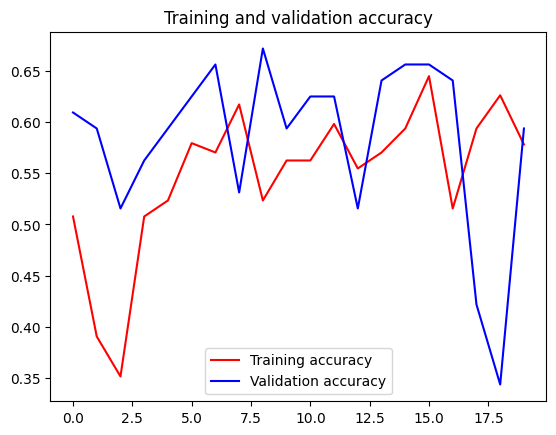

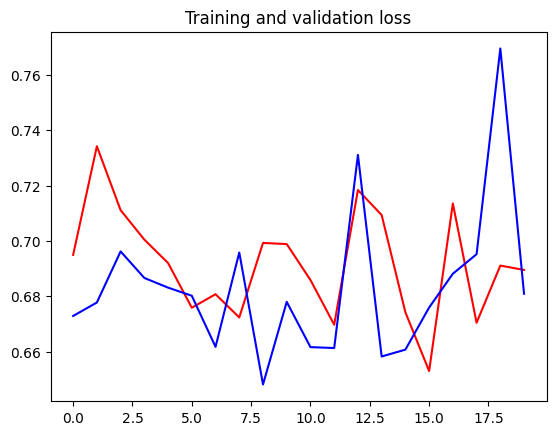

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.show()

In [ ]:
def build_model2():
  base_model = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
model=build_model2()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 21s 2s/step - loss: 1.2960 - accuracy: 0.5500 - val_loss: 0.7057 - val_accuracy: 0.5250
Epoch 2/20
4/4 [==============================] - 4s 1s/step - loss: 0.7628 - accuracy: 0.4500 - val_loss: 0.6581 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 3s 868ms/step - loss: 0.7551 - accuracy: 0.6750 - val_loss: 0.6442 - val_accuracy: 0.6750
Epoch 4/20
4/4 [==============================] - 2s 526ms/step - loss: 0.7042 - accuracy: 0.6250 - val_loss: 0.6929 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.6931 - accuracy: 0.5500 - val_loss: 0.6929 - val_accuracy: 0.5500
Epoch 6/20
4/4 [==============================] - 3s 838ms/step - loss: 0.7075 - accuracy: 0.5250 - val_loss: 0.7130 - val_accuracy: 0.4000
Epoch 7/20
4/4 [==============================] - 3s 884ms/step - loss: 0.6948 - accuracy: 0.5250 - val_loss: 0.6919 - val_accuracy: 0.6750
Epoch 8/20
4/4 [============

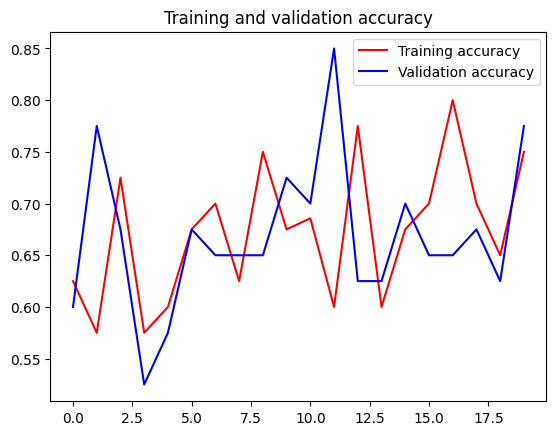

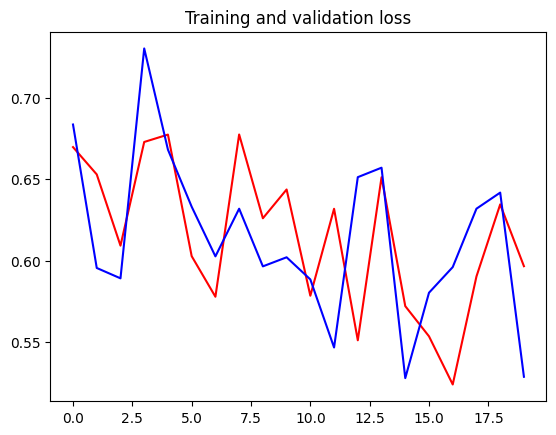

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.show()

In [ ]:
def build_model3():
  base_model = vgg16.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.SGD(0.001)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
model=build_model3()

AttributeError: ignored

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 4s 884ms/step - loss: 0.6696 - accuracy: 0.6250 - val_loss: 0.6835 - val_accuracy: 0.6000
Epoch 2/20
4/4 [==============================] - 4s 1s/step - loss: 0.6528 - accuracy: 0.5750 - val_loss: 0.5954 - val_accuracy: 0.7750
Epoch 3/20
4/4 [==============================] - 3s 1s/step - loss: 0.6092 - accuracy: 0.7250 - val_loss: 0.5891 - val_accuracy: 0.6750
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.6728 - accuracy: 0.5750 - val_loss: 0.7301 - val_accuracy: 0.5250
Epoch 5/20
4/4 [==============================] - 3s 982ms/step - loss: 0.6773 - accuracy: 0.6000 - val_loss: 0.6680 - val_accuracy: 0.5750
Epoch 6/20
4/4 [==============================] - 3s 849ms/step - loss: 0.6027 - accuracy: 0.6750 - val_loss: 0.6330 - val_accuracy: 0.6750
Epoch 7/20
4/4 [==============================] - 3s 688ms/step - loss: 0.5778 - accuracy: 0.7000 - val_loss: 0.6026 - val_accuracy: 0.6500
Epoch 8/20
4/4 [=============

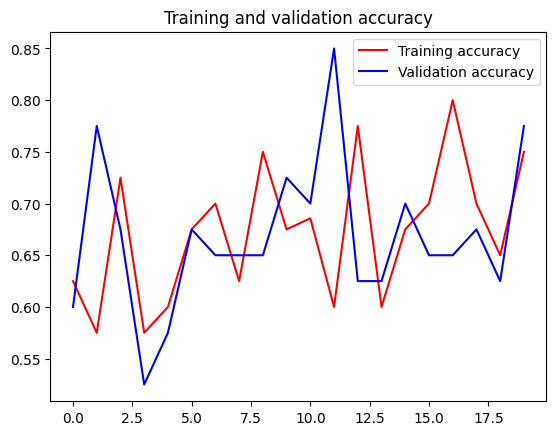

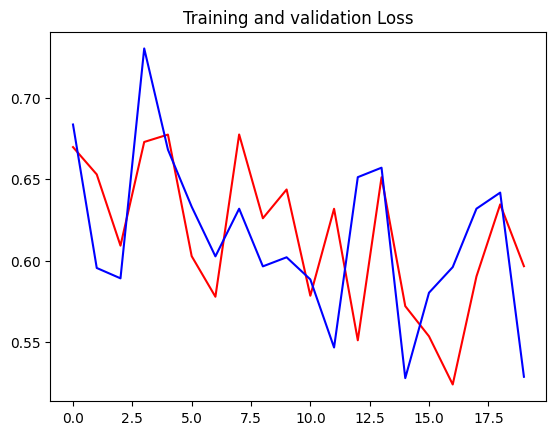

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')

plt.show()